# Experiments on MDP

## Experiment 1: A Deterministic Career Path

Consider a simple Markov Decision Process below with four states and two actions available at each state. In this simplistic setting actions have deterministic effects, i.e., taking an action in a state always leads to one next state with transition probability equal to one. There are two actions out of each state for the agent to choose from: D for development and R for research. The _ultimately-care-only-about-money_ reward scheme is given along with the states.

<img src='https://raw.githubusercontent.com/Muskman/ee932-reinforcement-learning/main/pa2/assets/mdp-d.png' width="700" align="left"></img>

In [ ]:
# Import essential libraries for MDP experiments.
# These cover environment setup, numerical operations, plotting, and randomness.
import gymnasium as gym
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import random

In [ ]:
# Set up argument parsing and configuration for experiments.
# Loads settings from config.json and handles reproducibility via seed.
import argparse, json
with open("config.json") as f:
    config = json.load(f)
parser = argparse.ArgumentParser(add_help=False)
parser.add_argument("--policy", choices=["R", "D", "uncertain", "random"], default="D")
parser.add_argument("--seed", type=int)  # optional: makes "random" reproducible
CLI = ""  # e.g., "--policy random --seed 7" or "--policy R"
seed = config.get("seed", None)
if seed is not None:
    np.random.seed(seed)
    random.seed(seed)
else:
    seed = 1990
    np.random.seed(seed)
    random.seed(seed)
print(f"Using seed {seed}")

Using seed 42


### 1.1 Environment Implementation

In [106]:
'''
Represents a Career Path problem Gym Environment which provides a Fully observable
MDP
'''
class CareerPathEnv(gym.Env):
    '''
    CareerPathEnv represents the Gym Environment for the Career Path problem environment
    States : [0:'Unemployed',1:'Industry',2:'Grad School',3:'Academia']
    Actions : [0:'Research', 1:'Development']
    '''
    metadata = {'render.modes': ['human']}

    def __init__(self,initial_state=0,no_states=4,no_actions=2):
        '''
        Constructor for the CareerPath class

        Args:
            initial_state : starting state of the agent
            no_states : The no. of possible states which is 4
            no_actions : The no. of possible actions which is 2

        '''
        self.initial_state = initial_state
        self.state = self.initial_state
        self.nA = no_actions
        self.nS = no_states
        self.prob_dynamics = {
            # s: {
            #   a: [(p(s,s'|a), s', r', terminal/not)]
            # }

            0: {
                0: [(1.0, 2, 0.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            1: {
                0: [(1.0, 0, -10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            2: {
                0: [(1.0, 3, 10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            3: {
                0: [(1.0, 3, 10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
        }
        self.reset()

    def reset(self):
        '''
        Resets the environment
        Returns:
            observations containing player's current state
        '''
        self.state = self.initial_state
        return self.get_obs()

    def get_obs(self):
        '''
        Returns the player's state as the observation of the environment
        '''
        return (self.state)

    def render(self, mode='human'):
        '''
        Renders the environment
        '''
        print("Current state: {}".format(self.state))

    def sample_action(self):
        '''
        Samples and returns a random action from the action space
        '''

        return random.randint(0, self.nA - 1)
    def P(self):
        '''
        Defines and returns the probabilty transition matrix which is in the form of a nested dictionary
        '''
        self.prob_dynamics = {
            0: {
                0: [(1.0, 2, 0.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            1: {
                0: [(1.0, 0, -10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            2: {
                0: [(1.0, 3, 10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            3: {
                0: [(1.0, 3, 10.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
        }
        return self.prob_dynamics


    def step(self, action):
        '''
        Performs the given action
        Args:
            action : action from the action_space to be taking in the environment
        Returns:
            observation - returns current state
            reward - reward obtained after taking the given action
            done - True if the episode is complete else False
        '''
        if action >= self.nA:
            action = self.nA-1
        if action < 0:
            action = 0

        dynamics_tuple = self.prob_dynamics[self.state][action][0]
        self.state = dynamics_tuple[1]


        return self.state, dynamics_tuple[2], dynamics_tuple[3]

### 1.2 Policies

After implementing the environment let us see how to make decisions in the environment. Let $\pi_1(s) = R$ and $\pi_2(s) = D$ for any state be two policies. Let us see how these policies look like.

In [ ]:
# Policy definitions for the Career Path MDP
policy_R = np.concatenate((np.ones([4, 1]), np.zeros([4, 1])), axis=1) # Research policy
policy_D = np.concatenate((np.zeros([4, 1]), np.ones([4, 1])), axis=1) # Development policy
policy_random = np.array((np.random.permutation(2), np.random.permutation(2), np.random.permutation(2), np.random.permutation(2))) # Random policy
policy_uncertain = np.concatenate((0.5*np.ones([4, 1]), 0.5*np.ones([4, 1])), axis=1) # Uncertain policy
print("Research policy: \n",policy_R)
print("Development policy: \n", policy_D)
print("Random policy: \n",policy_random)
print("Uncertain policy: \n",policy_uncertain)


Research policy: 
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Development policy: 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Random policy: 
 [[1 0]
 [0 1]
 [1 0]
 [1 0]]
Uncertain policy: 
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


### 1.3 Testing

By usine one of the above policies, lets see how we navigate the environment. We want to see how we make take and action based on a given policy, what state we transition to and obtain the rewards from the transition.

In [ ]:
# Test navigation in the deterministic Career Path environment using a selected policy
det_env = CareerPathEnv()
is_Terminal = False
start_state = det_env.reset()
steps = 0
total_reward = 0

if config.get("policy") == "Research":
    policy = policy_R
elif config.get("policy") == "Development":
    policy = policy_D
elif config.get("policy") == "Uncertain":
    policy = policy_uncertain
else: # "Random"
    policy = policy_random
print(f"[using policy = {config.get('policy')}, seed = {seed}]")
print(policy)

print("State\t", "Action\t" , "New State\t" , "Reward\t" , "is_Terminal")
steps = 0
max_steps = 5
prev_state = start_state

while steps < 10:
    steps += 1
    action = np.random.choice(2,1,p=policy[prev_state])[0]  # 0: Research, 1: Development
    state, reward, is_Terminal = det_env.step(action)
    total_reward += reward
    print(" ",prev_state, "\t  ", action, "\t  ", state, "\t", reward, "\t  ", is_Terminal)
    prev_state = state

print("Total Number of steps:", steps)
print("Final Reward:", total_reward)


[using policy = Uncertain, seed = 42]
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
State	 Action	 New State	 Reward	 is_Terminal
  0 	   1 	   1 	 100.0 	   False
  1 	   1 	   1 	 100.0 	   False
  1 	   0 	   0 	 -10.0 	   False
  0 	   0 	   2 	 0.0 	   False
  2 	   0 	   3 	 10.0 	   False
  3 	   1 	   1 	 100.0 	   False
  1 	   1 	   1 	 100.0 	   False
  1 	   1 	   1 	 100.0 	   False
  1 	   0 	   0 	 -10.0 	   False
  0 	   1 	   1 	 100.0 	   False
Total Number of steps: 10
Final Reward: 590.0


### 1.4 Iterative Policy Evaluation
Iterative Policy Evaluation is commonly used to calculate the state value function $V_\pi(s)$ for a given policy $\pi$. Here we implement a function to compute the state value function $V_\pi(s)$ for a given policy

<img src='https://raw.githubusercontent.com/Muskman/ee932-reinforcement-learning/main/pa2/assets/policy_eval.png' width="500" align="left"></img>

In [ ]:
def EvaluatePolicy(env, policy, gamma=0.9, theta=1e-8, draw=False):
    """
    Policy Evaluation for MDP: computes state values for a given policy.

    Args:
        env: MDP environment with nS, nA, and P()
        policy: Policy matrix (nS x nA)
        gamma: Discount factor
        theta: Convergence threshold
    Returns:
        V: State values under the given policy
    """
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P()[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V


### 1.5 Policy improvement

$\pi'(s) = \arg \max_a \sum_{s',r} p(s',r|s,a)\left[ r + \gamma v_\pi(s') \right ]$


In [ ]:
def ImprovePolicy(env, v, gamma):
    """
    Policy Improvement for MDP: returns a greedy policy given state values.

    Args:
        env: MDP environment with nS, nA, and P()
        v: State values
        gamma: Discount factor
    Returns:
        new_pi: Greedy policy matrix (nS x nA)
    """
    num_states = env.nS
    num_actions = env.nA
    prob_dynamics = env.P()
    q = np.zeros((num_states, num_actions))
    for state in prob_dynamics:
        for action in prob_dynamics[state]:
            for prob, new_state, reward, is_terminal in prob_dynamics[state][action]:
                q[state][action] += prob*(reward + gamma*v[new_state])
    new_pi = np.zeros((num_states, num_actions))
    for state in range(num_states):
        opt_action = np.argmax(q[state])
        new_pi[state][opt_action] = 1.0
    return new_pi


### 1.6 Policy Iteration

<img src='https://raw.githubusercontent.com/Muskman/ee932-reinforcement-learning/main/pa2/assets/policy_iteration.png' width="500" align="left"></img>

In [ ]:
def PolicyIteration(env, pi_init, gamma=0.9, theta=1e-8):
    """
    Policy Iteration for MDP: alternates evaluation and improvement until policy stabilizes.

    Args:
        env: MDP environment with nS, nA, and P()
        pi_init: Initial policy matrix (nS x nA)
        gamma: Discount factor
        theta: Convergence threshold
    Returns:
        pi: Optimal action indices for each state
        V: State values
        deltas: Max value change per evaluation sweep
    """
    nS, nA = env.nS, env.nA
    V = np.zeros(nS)
    pi = pi_init.copy()
    deltas = []
    P = env.P()
    while True:
        # Policy evaluation
        while True:
            delta = 0.0
            for s in range(nS):
                v = V[s]
                Vs = 0.0
                for a, action_prob in enumerate(pi[s]):
                    for p, ns, r, done in P[s][a]:
                        Vs += action_prob * p * (r + gamma * V[ns])
                V[s] = Vs
                delta = max(delta, abs(v - V[s]))
            deltas.append(delta)
            if delta < theta:
                break
        # Policy improvement
        pi_new = ImprovePolicy(env, V, gamma)
        if np.array_equal(np.argmax(pi, axis=1), np.argmax(pi_new, axis=1)):
            break
        pi = pi_new
    return np.argmax(pi, axis=1), V, deltas


### 1.7 Testing Policy Iteration

In [ ]:
# Test Policy Iteration and gather stats
gamma = 0.9
pi_init = policy.copy()
print("Initial Policy: \n", pi_init)
pi, v, deltas_pi = PolicyIteration(det_env, pi_init, gamma)
print("Final Policy: \n", pi)
print("State Value Function: ", v)
print("Number of iterations for Policy Iteration: ", len(deltas_pi))

# Stats across random initial policies
avg_iters = 0
min_iters = 10**9
max_iters = 0
for _ in range(100):
    policy_random = np.array((np.random.permutation(2), np.random.permutation(2), np.random.permutation(2), np.random.permutation(2)))
    pi_pi, V_pi, deltas_pi = PolicyIteration(det_env, policy_random, gamma)
    iters_pi = len(deltas_pi)
    avg_iters += iters_pi
    min_iters = min(min_iters, iters_pi)
    max_iters = max(max_iters, iters_pi)
avg_iters /= 100
print("Iterations:")
print("Min\tMax\tAverage")
print(min_iters, "\t", max_iters, "\t", avg_iters)


Initial Policy: 
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
Final Policy: 
 [1 1 1 1]
State Value Function:  [999.99999992 999.99999992 999.99999992 999.99999992]
Number of iterations for Policy Iteration:  353
Iterations:
Min	Max	Average
220 	 417 	 286.7


***

### 1.8 Find an optimal policy to navigate the given environment using Value Iteration (VI)

<img src='https://raw.githubusercontent.com/Muskman/ee932-reinforcement-learning/main/pa2/assets/value_iteration.png' width="500" align="left"></img>

In [ ]:
def value_iteration_with_trace(env, gamma=0.9, theta=1e-8):
    """
    Value Iteration for MDP: finds optimal policy and state values.

    Args:
        env: MDP environment with nS, nA, and P()
        gamma: Discount factor
        theta: Convergence threshold
    Returns:
        policy: Optimal action indices for each state
        V: State values
        deltas: Max value change per iteration
    """
    n_states, n_actions = env.nS, env.nA
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    deltas = []
    P = env.P()
    while True:
        delta = 0
        for s in range(n_states):
            v = V[s]
            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_s, reward, done in P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_s])
            best_action = np.argmax(action_values)
            V[s] = action_values[best_action]
            policy[s] = best_action
            delta = max(delta, abs(v - V[s]))
        deltas.append(delta)
        if delta < theta:
            break
    return policy, V, deltas


### 1.9 Plotting Convergence of Value Iteration and Policy Iteration

In [53]:
def plot_convergence(deltas_vi, deltas_pi=None, title="Convergence"):
    """
    Plot convergence curves on a log-y axis.
    - deltas_vi: list/array of max ΔV per sweep from value_iteration_with_trace
    - deltas_pi: (optional) list/array of max ΔV per evaluation sweep from policy_iteration_with_trace
    - title: figure title
    """
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(deltas_vi, label="Value Iteration")
    if deltas_pi is not None:
        plt.plot(deltas_pi, label="Policy Iteration")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Max ΔV")
    plt.title(title)
    plt.legend()
    plt.show()

    # concise counts (no ambiguity about what's being reported)
    print("VI iterations:", len(deltas_vi), end="")
    if deltas_pi is not None:
        print(" | PI evaluation sweeps:", len(deltas_pi))
    else:
        print()


### 1.10 Testing Value Iterations

Optimal Policy (Deterministic MDP): [1 1 1 1]
State Values: [1000. 1000. 1000. 1000.]
Converged in 220 iterations

Sample rollouts (deterministic transitions):

Episode 1:
 Step 0: s=0(Unemployed), a=1, Next State=1(Industry), r=100.0
 Step 1: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 2: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 3: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 4: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 5: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 6: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 7: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 8: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 9: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Total Reward: 1000.0

Episode 2:
 Step 0: s=0(Unemployed), a=1, Next State=1(Industry), r=100.0
 Step 1: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 2: s=1(Industry), a=1, Next State=1(Industry), r=100

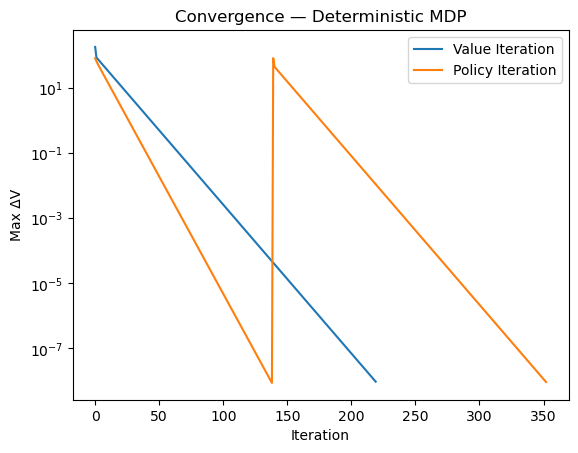

VI iterations: 220 | PI evaluation sweeps: 353


In [ ]:
# Section 1.10: Testing Value Iteration on the Deterministic Career Path
# This cell demonstrates how to use Value Iteration to find the optimal policy and state values in the deterministic environment.
# It also shows how to simulate rollouts with the learned policy and compares convergence between Value Iteration and Policy Iteration.
# These steps help illustrate how the agent learns and how quickly the algorithms converge.

# Set the discount factor for future rewards
gamma = 0.9

# Learn the optimal policy and state values using Value Iteration
pi_vi, V_vi, iters_vi = value_iteration_with_trace(det_env, gamma)
print("Optimal Policy (Deterministic MDP):", pi_vi)          # e.g., [1 1 1 1]
print("State Values:", np.round(V_vi, 2))                         # e.g., ~[1000, 1000, ...]
print("Converged in", len(iters_vi), "iterations")

# Optional: Use readable state names for clarity in rollouts
state_names = {0:"Unemployed", 1:"Industry", 2:"Grad School", 3:"Academia"}

# Simulate a few short rollouts with the learned policy to visualize agent behavior
print("\nSample rollouts (deterministic transitions):")
for ep in range(3):  # Run a couple of concise episodes
    state = det_env.reset()
    total_reward = 0
    print(f"\nEpisode {ep+1}:")
    for t in range(10):  # Short horizon for readable logs
        action = pi_vi[state]
        next_state, reward, done = det_env.step(action)
        s_name = state_names.get(state, state)
        ns_name = state_names.get(next_state, next_state)
        print(f" Step {t}: s={state}({s_name}), a={action}, Next State={next_state}({ns_name}), r={reward}")
        total_reward += reward
        state = next_state
        if done:
            break
    print(" Total Reward:", total_reward)

# Plot and compare convergence of Value Iteration and Policy Iteration
policy_random_for_plot = pi_init.copy()
pi_pi_plot, V_pi_plot, deltas_pi = PolicyIteration(det_env, policy_random_for_plot, gamma)
plot_convergence(iters_vi, deltas_pi, title="Convergence — Deterministic MDP")


### Section 1.11: Evaluating Policies in the Deterministic Career Path

In [ ]:
# Section 1.11: Evaluating Policies in the Deterministic Career Path
# This cell compares the value of the user-selected policy and the value of the optimal policy found by Value Iteration.
# It helps verify that the evaluation function works correctly and that the optimal policy truly yields the best state values.
# The results show whether the agent's chosen policy is as effective as the one learned by the algorithm.

# Evaluate the currently selected policy from Section 1.3
V_det_eval = EvaluatePolicy(det_env, policy, gamma)
print("Deterministic — V(policy from config):", np.round(V_det_eval, 2))

# Evaluate the VI-optimal policy using one-hot encoding; should match Value Iteration results
pi_vi_det, V_vi_det, _ = value_iteration_with_trace(det_env, gamma)
pi_vi_det_mat = np.eye(det_env.nA)[pi_vi_det]
V_det_vi_check = EvaluatePolicy(det_env, pi_vi_det_mat, gamma)
print("Deterministic — V(VI policy) via EvaluatePolicy:", np.round(V_det_vi_check, 2))


Deterministic — V(policy from config): [1000. 1000. 1000.  100.]
Deterministic — V(VI policy) via EvaluatePolicy: [1000. 1000. 1000. 1000.]


***

## Experiment 2 : A Stochastic Career Path

Now consider a more realistic Markov Decision Process below with four states and two actions available at each state. In this setting Actions have nondeterministic effects, i.e., taking an action in a state always leads to one next state, but which state is the one next state is determined by transition probabilities. These transition probabilites are shown in the figure attached to the transition arrows from states and actions to states. There are two actions out of each state for the agent to choose from: D for development and R for research. The same _ultimately-care-only-about-money_ reward scheme is given along with the states.

<img src='https://raw.githubusercontent.com/Muskman/ee932-reinforcement-learning/main/pa2/assets/mdp-nd.png' width="700" align="left"></img>

### 2.1 Environment Implementation (Stochastic)

The stochastic environment used in Experiment 2 is implemented as a Gym-style class below. It encodes probabilistic transitions and rewards for the same state/action space used in Experiment 1. (Per your requirement, I will not modify the class implementation itself; this markdown simply documents its role in the experiment.)

In [88]:
'''
Represents a Career Path problem Gym Environment which provides a Fully observable
MDP
'''
class StochasticCareerPathEnv(gym.Env):
    '''
    StocasticCareerPathEnv represents the Gym Environment for the Career Path problem environment
    States : [0:'Unemployed',1:'Industry',2:'Grad School',3:'Academia']
    Actions : [0:'Research', 1:'Development']
    '''
    metadata = {'render.modes': ['human']}

    def __init__(self,initial_state=3,no_states=4,no_actions=2):
        '''
        Constructor for the CareerPath class

        Args:
            initial_state : starting state of the agent
            no_states : The no. of possible states which is 4
            no_actions : The no. of possible actions which is 2

        '''
        self.initial_state = initial_state
        self.state = self.initial_state
        self.nA = no_actions
        self.nS = no_states
        self.prob_dynamics = {
            # s: {
            #   a: [(p(s,s'|a), s', r', terminal/not), (p(s,s''|a), s'', r'', terminal/not)]
            # }

            0: {
                0: [(1.0, 2, 0.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            1: {
                0: [(0.9, 0, -10.0, False),(0.1, 1, 100, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            2: {
                0: [(0.9, 3, 10.0, False),(0.1, 2, 0, False)],
                1: [(0.9, 1, 100.0, False),(0.1, 1, 100, False)],
            },
            3: {
                0: [(1.0, 3, 10.0, False)],
                1: [(0.9, 1, 100.0, False),(0.1, 3, 10, False)],
            },
        }
        self.reset()

    def reset(self):
        '''
        Resets the environment
        Returns:
            observations containing player's current state
        '''
        self.state = self.initial_state
        return self.get_obs()

    def get_obs(self):
        '''
        Returns the player's state as the observation of the environment
        '''
        return (self.state)

    def render(self, mode='human'):
        '''
        Renders the environment
        '''
        print("Current state: {}".format(self.state))

    def sample_action(self):
        '''
        Samples and returns a random action from the action space
        '''
        return random.randint(0, self.nA-1)
    def P(self):
        '''
        Defines and returns the probabilty transition matrix which is in the form of a nested dictionary
        '''
        self.prob_dynamics = {
            0: {
                0: [(1.0, 2, 0.0, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            1: {
                0: [(0.9, 0, -10.0, False),(0.1, 1, 100, False)],
                1: [(1.0, 1, 100.0, False)],
            },
            2: {
                0: [(0.9, 3, 10.0, False),(0.1, 2, 0, False)],
                1: [(0.9, 1, 100.0, False),(0.1, 1, 100, False)],
            },
            3: {
                0: [(1.0, 3, 10.0, False)],
                1: [(0.9, 1, 100.0, False),(0.1, 3, 10, False)],
            },
        }
        return self.prob_dynamics


    def step(self, action):
        '''
        Performs the given action
        Args:
            action : action from the action_space to be taking in the environment
        Returns:
            observation - returns current state
            reward - reward obtained after taking the given action
            done - True if the episode is complete else False
        '''
        if action >= self.nA: 
            action = self.nA - 1
        if action < 0: 
            action = 0

        outcomes = self.prob_dynamics[self.state][action]  # list of (p, s', r, done)
        probs = [p for p, _, _, _ in outcomes]
        idx = np.random.choice(len(outcomes), p=probs)
        _, next_state, reward, done = outcomes[idx]

        self.state = next_state
        return self.state, reward, done

### 2.2 Policies and Navigation

We reuse the policy matrices defined in Experiment 1 (e.g., `policy_R`, `policy_D`, `policy_uncertain`, `policy_random`). The code block below demonstrates how to run short rollouts in the stochastic environment using the selected policy. This section mirrors Experiment 1's structure so the notebook is consistent and easy to follow.

### Navigating in Stochastic Career Path

In [ ]:
# Section 2.2 & Navigating in Stochastic Career Path
# This cell demonstrates how to use a selected policy to navigate the stochastic career path environment.
# The agent starts in a given state and follows the chosen policy, with transitions determined by the environment's probabilities.
# Each step prints the current state, chosen action, resulting state, reward, and whether the episode has ended.
# This helps visualize how randomness in transitions affects the agent's journey and accumulated rewards.

sto_env = StochasticCareerPathEnv()
is_Terminal = False
start_state = sto_env.reset()
steps = 0
total_reward = 0

# Select the policy based on configuration (Research, Development, Uncertain, or Random)
if config.get("policy") == "Research":
    policy = policy_R
elif config.get("policy") == "Development":
    policy = policy_D
elif config.get("policy") == "Uncertain":
    policy = policy_uncertain
else: # "Random"
    policy = policy_random
print(f"[using policy = {config.get('policy')}, seed = {seed}]")
print(policy)

print("State\t", "Action\t" , "New State\t" , "Reward\t" , "is_Terminal")
max_steps = 10
prev_state = start_state

# Run the episode, taking actions according to the policy and observing stochastic transitions
while steps < max_steps and not is_Terminal:
    steps += 1
    action = np.random.choice(sto_env.nA, p=policy[prev_state])  # Action selection based on policy probabilities
    state, reward, is_Terminal = sto_env.step(action)
    total_reward += reward
    print(" ", prev_state, "\t  ", action, "\t  ", state, "\t", reward, "\t  ", is_Terminal)
    prev_state = state

print("Total Number of steps:", steps)
print("Final Reward:", total_reward)


[using policy = Uncertain, seed = 42]
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
State	 Action	 New State	 Reward	 is_Terminal
  3 	   1 	   1 	 100.0 	   False
  1 	   0 	   0 	 -10.0 	   False
  0 	   0 	   2 	 0.0 	   False
  2 	   0 	   3 	 10.0 	   False
  3 	   1 	   1 	 100.0 	   False
  1 	   0 	   0 	 -10.0 	   False
  0 	   0 	   2 	 0.0 	   False
  2 	   0 	   3 	 10.0 	   False
  3 	   1 	   1 	 100.0 	   False
  1 	   1 	   1 	 100.0 	   False
Total Number of steps: 10
Final Reward: 400.0


### 2.3 Find an optimal policy to navigate the given SCP environment using Policy Iteration (PI)

In [ ]:
# Policy Improvement (works for BOTH deterministic and stochastic)
def ImprovePolicy(env, v, gamma):
    """Compute a greedy deterministic policy from a value function `v`.

    This function performs a one-step lookahead to compute q(s,a) = E[r + gamma * v(s')]
    for each (s,a) pair and returns a one-hot policy that selects the action
    with the highest expected return for each state.

    Args:
        env: environment exposing `nS`, `nA`, and `P()`
        v: numpy array of length nS containing the estimated state values
        gamma: discount factor (0 <= gamma < 1 normally)

    Returns:
        new_pi: (nS x nA) numpy array where each row is a one-hot vector selecting
                the greedy action for that state.
    """
    num_states = env.nS
    num_actions = env.nA
    P = env.P()

    q = np.zeros((num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            for prob, ns, r, done in P[s][a]:
                # accumulate expected one-step return for (s,a)
                q[s][a] += prob * (r + gamma * v[ns])

    new_pi = np.zeros((num_states, num_actions))
    for s in range(num_states):
        opt_a = np.argmax(q[s])
        new_pi[s][opt_a] = 1.0
    return new_pi


def EvaluatePolicy_stochastic(env, policy, gamma):
    """Evaluate a (possibly stochastic) policy in an MDP with probabilistic transitions.

    Uses iterative policy evaluation (Bellman expectation) until the sup-norm
    change is below a small tolerance. The implementation mirrors the deterministic
    version but explicitly handles multiple outcomes per action.

    Args:
        env: environment exposing `nS` and `P()`
        policy: (nS x nA) numpy array where each row is a distribution over actions
        gamma: discount factor

    Returns:
        V: numpy array of length `nS` containing estimated state values under `policy`.
    """
    V = np.zeros(env.nS)
    theta = 1e-8
    P = env.P()
    while True:
        delta = 0.0
        for s in range(env.nS):
            Vs = 0.0
            # expectation under the (possibly stochastic) policy at state s
            for a, action_prob in enumerate(policy[s]):
                for prob, ns, r, done in P[s][a]:
                    Vs += action_prob * prob * (r + gamma * V[ns])
            delta = max(delta, abs(V[s] - Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V


def policy_iteration_stochastic_with_trace_from(env, pi_init, gamma=0.9, theta=1e-8):
    """Policy iteration for stochastic MDPs that returns a convergence trace.

    This function alternates iterative policy evaluation (under the current
    policy distribution) and greedy policy improvement until the greedy actions
    stop changing. It returns the final action indices, the converged value
    function, and a list of deltas recorded during evaluation sweeps for
    diagnostic plotting.

    Args:
        env: environment with `nS`, `nA`, and `P()`
        pi_init: initial policy, either as a matrix (nS x nA) or an index vector
        gamma: discount factor
        theta: tolerance for evaluation convergence

    Returns:
        (pi_actions, V, deltas)
    """
    nS, nA = env.nS, env.nA
    P = env.P()
    V = np.zeros(nS)
    # ensure matrix policy; if indices are passed, make one-hot
    pi = pi_init.copy()
    if pi.ndim == 1:
        pi = np.eye(nA)[pi]
    deltas = []

    while True:
        # --- policy evaluation (iterative) with ΔV tracking under the policy distribution ---
        while True:
            delta = 0.0
            for s in range(nS):
                v_old = V[s]
                Vs = 0.0
                for a, action_prob in enumerate(pi[s]):
                    for p, ns, r, done in P[s][a]:
                        Vs += action_prob * p * (r + gamma * V[ns])
                V[s] = Vs
                delta = max(delta, abs(v_old - V[s]))
            deltas.append(delta)
            if delta < theta:
                break

        # --- policy improvement (greedy w.r.t. V) ---
        pi_new = ImprovePolicy(env, V, gamma)

        # stop if greedy actions didn't change
        if np.array_equal(np.argmax(pi_new, axis=1), np.argmax(pi, axis=1)):
            break
        pi = pi_new

    # return action indices for consistency with other PI code
    return np.argmax(pi, axis=1), V, deltas

### 2.4 Find an optimal policy to navigate the given SCP environment using Value Iteration (VI)

In [111]:
def value_iteration_stochastic_with_trace(env, gamma=0.9, theta=1e-8):
    """Value iteration for MDPs with stochastic transitions.

    Identical interface to `value_iteration_with_trace` but kept separate to make
    experiment code explicit and readable. The function performs Bellman optimal
    updates until the maximal change in V falls below `theta` and returns the
    greedy policy, value function and per-iteration deltas for plotting.

    Args:
        env: environment with `nS`, `nA`, and `P()`
        gamma: discount factor
        theta: stopping tolerance for the Bellman error (sup-norm)

    Returns:
        (policy, V, deltas)
    """
    n_states, n_actions = env.nS, env.nA
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    deltas = []
    P = env.P()
    while True:
        delta = 0.0
        for s in range(n_states):
            v = V[s]
            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_state])
            best_a = np.argmax(action_values)
            V[s] = action_values[best_a]
            policy[s] = best_a
            delta = max(delta, abs(v - V[s]))
        deltas.append(delta)
        if delta < theta:
            break
    return policy, V, deltas

### 2.5 Compare PI and VI in terms of convergence (average number of iteration, time required for each iteration). Is the policy obtained by both same for SCP environment?


Optimal Policy (Stochastic MDP): [1 1 1 1]
State Values: [1000.   1000.   1000.    990.11]
Converged in 220 iterations

Sample rollouts with stochastic transitions:

Episode 1:
 Step 0: s=3(Academia), a=1, Next State=1(Industry), r=100.0
 Step 1: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 2: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 3: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 4: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 5: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 6: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 7: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 8: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 9: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Total Reward: 1000.0

Episode 2:
 Step 0: s=3(Academia), a=1, Next State=1(Industry), r=100.0
 Step 1: s=1(Industry), a=1, Next State=1(Industry), r=100.0
 Step 2: s=1(Industry), a=1, Next State=1(Industry), r=10

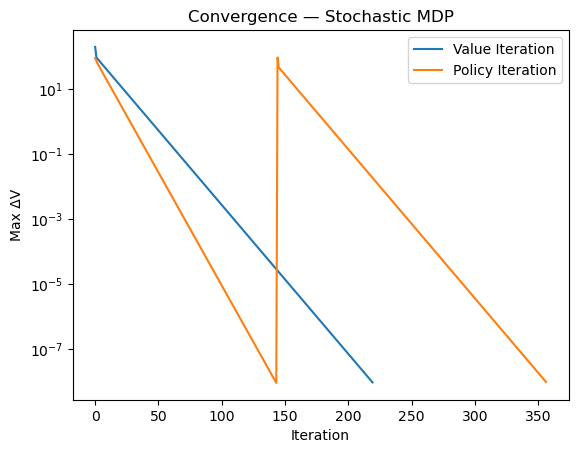

VI iterations: 220 | PI evaluation sweeps: 357


In [ ]:
# Section 2.5: Comparing Policy Iteration (PI) and Value Iteration (VI) for Stochastic MDPs
# This cell runs both VI and PI algorithms on the stochastic career path environment,
# prints the optimal policies and state values, and visualizes their convergence behavior.
# Reviewer note: This comparison helps illustrate the relative speed and stability of each method.

# Run Value Iteration to find the optimal policy and value function
gamma = 0.9
pi_vi_sto, V_sto, deltas_vi_sto = value_iteration_stochastic_with_trace(sto_env, gamma)
print("Optimal Policy (Stochastic MDP):", pi_vi_sto)
print("State Values:", np.round(V_sto, 2))
print("Converged in", len(deltas_vi_sto), "iterations")

# Show sample rollouts using the learned VI policy for interpretability
state_names = {0:"Unemployed", 1:"Industry", 2:"Grad School", 3:"Academia"}
print("\nSample rollouts with stochastic transitions:")
for ep in range(3):
    state = sto_env.reset()
    total_reward = 0
    print(f"\nEpisode {ep+1}:")
    for t in range(10):
        action = pi_vi_sto[state]
        next_state, reward, done = sto_env.step(action)
        s_name = state_names.get(state, state)
        ns_name = state_names.get(next_state, next_state)
        total_reward += reward
        print(f" Step {t}: s={state}({s_name}), a={action}, Next State={next_state}({ns_name}), r={reward}")
        state = next_state
        if done:
            break
    print(" Total Reward:", total_reward)

# Run Policy Iteration starting from the same initial policy for a fair comparison
pi_init = policy.copy()  # Use the config-chosen matrix as the starting point
pi_pi_sto, V_pi_sto, deltas_pi_sto = policy_iteration_stochastic_with_trace_from(sto_env, pi_init, gamma)

# Plot and compare the convergence of VI and PI
plot_convergence(deltas_vi_sto, deltas_pi_sto, title="Convergence — Stochastic MDP")

## Appendix: Sanity Checks (call the functions once)

In [ ]:
# === Appendix: Sanity-check the evaluation functions (Det + Sto) ===
# This appendix cell runs quick sanity checks to verify that policy evaluation and value iteration
# functions work as expected for both deterministic and stochastic environments.
# It prints the computed state values and checks for consistency between different evaluation methods.

import numpy as np

# Use the gamma value from earlier if available, otherwise default to 0.9
if 'gamma' in globals():
    gamma = gamma
else:
    gamma = 0.9

# --- Deterministic MDP checks ---
# Evaluate the chosen policy matrix from above in the deterministic environment
V_det_eval = EvaluatePolicy(det_env, policy, gamma)
print("Deterministic — V(policy from config):", np.round(V_det_eval, 2))

# Evaluate the VI-optimal policy using one-hot encoding; should match value iteration results
pi_vi_det, V_vi_det, _ = value_iteration_with_trace(det_env, gamma)
pi_vi_det_mat = np.eye(det_env.nA)[pi_vi_det]
V_det_vi_check = EvaluatePolicy(det_env, pi_vi_det_mat, gamma)
print("Deterministic — V(VI policy) via EvaluatePolicy:", np.round(V_det_vi_check, 2))

# Reviewer note: The following assertion is optional and checks that both methods agree
# assert np.allclose(V_det_vi_check, V_vi_det, atol=1e-6)

# --- Stochastic MDP checks ---
# Make sure the stochastic environment exists
if 'sto_env' in globals():
    sto_env = sto_env
else:
    sto_env = StochasticCareerPathEnv()

# Evaluate the chosen policy matrix in the stochastic environment
V_sto_eval = EvaluatePolicy_stochastic(sto_env, policy, gamma)
print("Stochastic — V(policy from config):", np.round(V_sto_eval, 2))

# Evaluate the VI-optimal policy in the stochastic environment using one-hot encoding
pi_vi_sto, V_vi_sto, _ = value_iteration_stochastic_with_trace(sto_env, gamma)
pi_vi_sto_mat = np.eye(sto_env.nA)[pi_vi_sto]
V_sto_vi_check = EvaluatePolicy_stochastic(sto_env, pi_vi_sto_mat, gamma)
print("Stochastic — V(VI policy) via EvaluatePolicy_stochastic:", np.round(V_sto_vi_check, 2))




Deterministic — V(policy from config): [489.87 482.62 494.87 494.87]
Deterministic — V(VI policy) via EvaluatePolicy: [1000. 1000. 1000. 1000.]
Stochastic — V(policy from config): [509.   508.21 511.79 507.57]
Stochastic — V(VI policy) via EvaluatePolicy_stochastic: [1000.   1000.   1000.    990.11]
